From the Kaggle Datathon Summary:

### Why oil palm?
Deforestation through oil palm plantation growth represents an agricultural trend with large economic and environmental impacts. From shampoo to donuts and ice cream, oil palm is present in many everyday products—but many have never heard of it explicitly! Because oil palm grows only in tropical environments, the crop’s expansion has led to deforestation, increased carbon emissions, and biodiversity loss, while at the same time providing many valuable jobs.

With the economic livelihoods of millions and the ecosystems of the tropics at stake, how might we work towards affordable, timely, and scalable ways to address the expansion and management of oil palm throughout the world?

High-resolution satellite imagery is a global, regularly-updated, and accurate source of data. Coupled with computer vision algorithms, it presents a promising opportunity for automated mapping of oil palm plantations, an important step toward understanding global impact.

In [1]:
import numpy as np
import os
import time
import torch
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict
from PIL import Image
from PIL import ImageFile
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set image locations
train_image_dir = 'data/palm_train/'
test_image_dir = 'data/leaderboard_test_data/'
holdout_image_dir = 'data/leaderboard_holdout_data/'
has_palm_dir = 'data/palm_train/palm/palm/'
no_palm_dir = 'data/palm_train/no_palm/no_palm/'

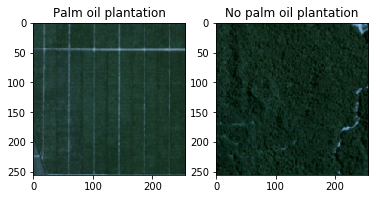

In [4]:
import cv2

plt.subplot(1,2,1)
has_palm_names = os.listdir(has_palm_dir)
plt.imshow(cv2.imread(has_palm_dir + has_palm_names[0]))
plt.title("Palm oil plantation")
plt.grid(False)
plt.subplot(1,2,2)
no_palm_names = os.listdir(no_palm_dir)
plt.title("No palm oil plantation")
plt.imshow(cv2.imread(no_palm_dir + no_palm_names[2]))
plt.show()

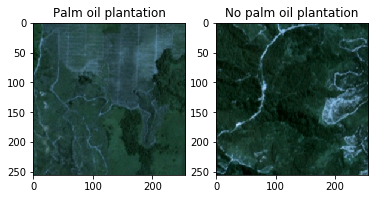

In [5]:
plt.subplot(1,2,1)
has_palm_names = os.listdir(has_palm_dir)
plt.imshow(cv2.imread(has_palm_dir + has_palm_names[5]))
plt.title("Palm oil plantation")
plt.grid(False)
plt.subplot(1,2,2)
no_palm_names = os.listdir(no_palm_dir)
plt.title("No palm oil plantation")
plt.imshow(cv2.imread(no_palm_dir + no_palm_names[6]))
plt.show()

In [3]:
# load and transform data

# set data transforms
train_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ColorJitter(brightness=.5, contrast=0.75),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                     ])

transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                     ])

# load data with ImageFolder
train_dataset = datasets.ImageFolder(train_image_dir, transform=train_transform)

holdout_dataset = datasets.ImageFolder(holdout_image_dir, transform=transform)

# competition test dataset, not to be confused with the 'test' set extracted from the training data
comp_test_dataset = datasets.ImageFolder(test_image_dir, transform=transform)

In [4]:
# train/validation split
# later write a sampler that indices from majority and minority class to combine

valid_size=0.2

num_train = len(train_dataset) # include palm and no palm imgs
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train)) # np.floor rounds down a float

train_idx, valid_idx = indices[split:], indices[:split]

num_valid = len(valid_idx)
indices = list(range(num_valid))
valid_size = 0.5
split = int(np.floor(valid_size * num_valid))
valid_idx, test_idx = indices[split:], indices[:split]

# define subset sampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [5]:
# defining parameters for dataloader
num_workers = 0
batch_size = 32

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers)

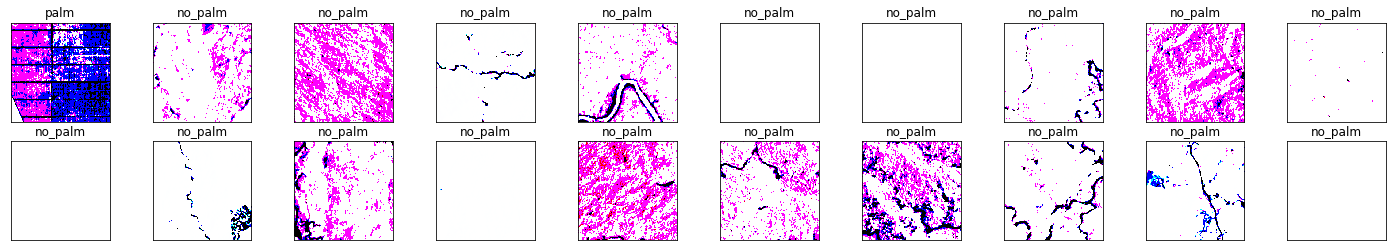

In [6]:
# visualize the data

# index to class mapping
idx_to_class = dict((v, k) for k, v in train_dataset.class_to_idx.items())

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy().astype(np.uint8) # have to use numpy because the images are Tensors - incompatible with plt
labels = labels.numpy()

# plot images in batch
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0))) # transpose to get data in format with height/width and number of channels
    ax.set_title("{}".format(idx_to_class[labels[idx]]))

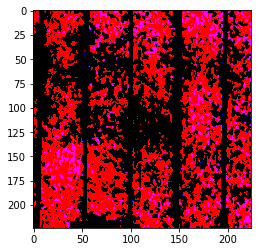

In [25]:
plt.imshow(np.transpose(images[10], (1, 2, 0)))

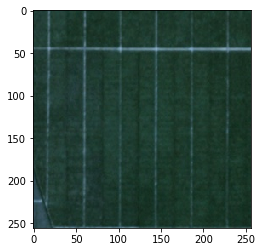

In [51]:
palm_image = cv2.imread(has_palm_dir + has_palm_names[0])
plt.imshow(palm_image)
plt.savefig('images/original.png')
plt.close(fig)

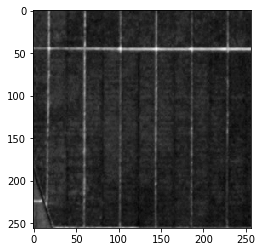

In [48]:
gray = cv2.cvtColor(palm_image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')
plt.savefig('images/grayscale.png')
plt.close(fig)

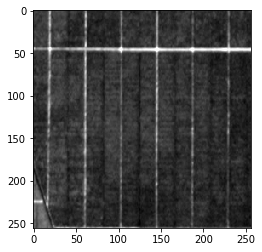

In [52]:
custom_2x2 = np.array([[1,0],
                       [1,0]])

filtered_image = cv2.filter2D(gray, -1, custom_2x2)

plt.imshow(filtered_image, cmap='gray')

plt.savefig('images/2x2_filter.png')
plt.close(fig)

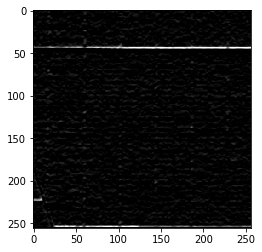

In [53]:
sobel_y = np.array([[ -1, -2, -1], 
                   [ 0, 0, 0], 
                   [ 1, 2, 1]])

# Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)  
filtered_image = cv2.filter2D(gray, -1, sobel_y)

plt.imshow(filtered_image, cmap='gray')

plt.savefig('images/sobely_filter.png')
plt.close(fig)

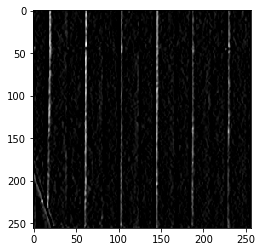

In [54]:
sobel_x = np.array([[ 1, 0, -1], 
                   [ 2, 0, -2], 
                   [ 1, 0, -1]])

# Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)  
filtered_image = cv2.filter2D(gray, -1, sobel_x)

plt.imshow(filtered_image, cmap='gray')

plt.savefig('images/sobelx_filter.png')
plt.close(fig)